Setup

In [21]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import re
from scipy import stats
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


## Load and Prepare the Datasets

In [2]:
# Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')
data_dir = working_dir + 'data/PROTECTED_DATA/BGI_Expression_Data/'


## Load Transcriptomics Data 
transcriptomics_TPM_dataset_dir = data_dir + 'CRC.SW.mRNA.symbol.TPM_NOnormal.csv'  
transcriptomics_dataset = pd.read_csv(transcriptomics_TPM_dataset_dir, index_col=0)

# Classification Tags
labels_classification_dir = data_dir + 'ClassTags_PrimarySiteDisease.csv' # Using only tumor samples
labels = pd.read_csv(labels_classification_dir, index_col=0)


# Figures Saving output dir


# Convert The directory to the name of the column
trait_used_as_label = labels_classification_dir.replace(data_dir, '').replace('ClassTags_', '').replace('.csv', '')
trait_used_as_label = re.sub(r'(?<=\w)([A-Z])', r' \1', trait_used_as_label) # Add spaces before the capital letters for formatting

# Convert labels to categorical values
class_values = labels[trait_used_as_label].astype('category').cat.codes
labels['label'] = class_values






## Make a subset to save RAM
subset_dataset_size = 2000
transcriptomics_dataset = transcriptomics_dataset.iloc[:, :subset_dataset_size] 

# RAM usage estimation in GB
RAM_estimate = (subset_dataset_size * subset_dataset_size * 8) / (1024**3)
print(f"The aproximated RAM to analyse this size of dataset is: {RAM_estimate} GB")


The aproximated RAM to analyse this size of dataset is: 0.029802322387695312 GB


## Prepare Data for the Model

### Preprocessing

Preprocess the data using the same method as in the WGCNA approach

preprocess_TPM_outlier_deletion function removed 96 genes
preprocess_TPM_outlier_deletion function removed 1 pacients


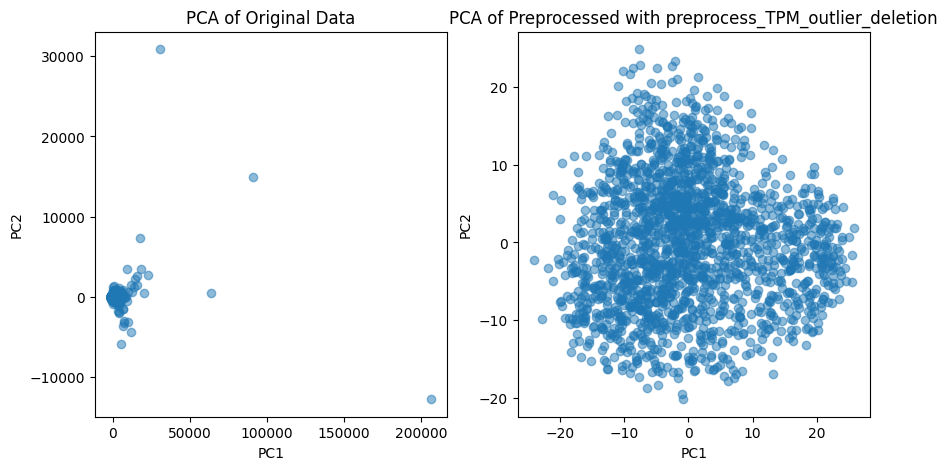

In [3]:
def preprocess_TPM_outlier_deletion(raw_data, expression_th):

    """
    Cleans raw data by filtering out low expression genes, applying log transformation, and removing outliers based on PCA analysis.
    
    Parameters:
    - raw_data (DataFrame): The raw data as a pandas DataFrame.
    - expression_th (int): The value of expression under which genes are eliminated.
    
    Returns:
    - DataFrame: The dataset after preprocessing and outlier removal.
    """
    # Filter out genes with low expression across all samples
    cleaned_dataset = raw_data.loc[:, (raw_data > expression_th).any(axis=0)].copy()
    
    # Apply log2 transformation to all values except for the first column (gene identifiers)
    cleaned_dataset.iloc[:, 1:] = np.log2(cleaned_dataset.iloc[:, 1:] + 1)
    
    # Outlier detection and removal based on PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(cleaned_dataset.iloc[:, 1:])  # NOT Transpose to have samples as rows for PCA
    z_scores = np.abs(stats.zscore(pca_result, axis=0))
    good_samples = (z_scores < 3).all(axis=1)                      # Keeping samples within 3 standard deviations
    cleaned_dataset = cleaned_dataset[good_samples]

    # Data Standardization (Z-score normalization)
    cleaned_dataset.iloc[:, 1:] = cleaned_dataset.iloc[:, 1:].apply(stats.zscore, axis=0)

    # Print the number of genes removed
    num_genes_removed = raw_data.shape[1] - cleaned_dataset.shape[1]
    print(f"preprocess_TPM_outlier_deletion function removed {num_genes_removed} genes")

    # Print the number of genes removed
    num_pacients_removed = raw_data.shape[0] - cleaned_dataset.shape[0]
    print(f"preprocess_TPM_outlier_deletion function removed {num_pacients_removed} pacients")

    return cleaned_dataset

def plot_pca(dataframe, title, ax = None):
    """
    Performs PCA on the provided dataframe and plots the first two principal components for visualization.
    
    Parameters:
    - dataframe (DataFrame): The dataframe to perform PCA on.
    - title (str): The title of the plot.
    
    Returns:
    - None, it generates the plot
    """
    # Perform PCA analysis
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe.iloc[:, 1:].T)

    # Plot the first two principal components
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')


transcriptomics_clean = preprocess_TPM_outlier_deletion(transcriptomics_dataset, expression_th = 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_pca(transcriptomics_dataset, title='PCA of Original Data', ax=axs[0])
plot_pca(transcriptomics_clean, title='PCA of Preprocessed with preprocess_TPM_outlier_deletion', ax=axs[1])

### Graph representation of the dataset

We Tranform the dataset into a network representation. This can be done in many ways, we opt for a self-similarity matrix based on correlation as a metric of similarity

As per the paper:
To create the co-expression graph, Spearman correlation was calculated to generate a correlation matrix between each gene in the dataset.
Spearman Correlation is a widely adopted method to assess monotonic linear or non-linear relationships in sequencing data. 
If the correlation between two genes is >0.6 with a p < 0.05, a weight of 1 is placed in an adjacency matrix, otherwise 0. If there is no correlation >0.6 with a given gene, then that gene is removed from the gene list, leading to the total of genes in the co-expression graph.

In [4]:
## Step 0: Turn dataframe into NumPy matrix for efficiency
transcriptomics_np = transcriptomics_clean.to_numpy()

# Step 1: Calculate Spearman Correlation and p-values
correlations, pvalues = stats.spearmanr(transcriptomics_np)

# Step 2: Construct the Adjacency Matrix
adjacency_matrix_np = (correlations > 0.6) & (pvalues < 0.05)
adjacency_matrix_np = adjacency_matrix_np.astype(int)
adjacency_matrix = pd.DataFrame(adjacency_matrix_np, index=transcriptomics_clean.columns, columns=transcriptomics_clean.columns)

# Step 3: Remove Isolated Genes - does not correlate >0.6 with any other gene
is_not_isolated = adjacency_matrix.sum(axis=1) > 0
filtered_adjacency_matrix = adjacency_matrix.loc[is_not_isolated, is_not_isolated]
print(f'{transcriptomics_clean.shape[1]-filtered_adjacency_matrix.shape[0]} genes were removed as Isolated Genes')

0 genes were removed as Isolated Genes


In [31]:
# Step 0: Given 'transcriptomics_clean' DataFrame, ensure 'transcriptomics_np' is updated after filtering
transcriptomics_np_filtered  = transcriptomics_clean.loc[:, is_not_isolated].to_numpy()

# Step 1: Convert the filtered adjacency matrix to a sparse format
sparse_adjacency_matrix = sparse.csr_matrix(filtered_adjacency_matrix.values)


# Convert sparse adjacency matrix to TensorFlow sparse tensor
adjacency_matrix_tensor = tf.sparse.SparseTensor(indices=np.array(list(zip(*sparse_adjacency_matrix.nonzero()))),
                                                 values=sparse_adjacency_matrix.data.astype(np.float32),
                                                 dense_shape=sparse_adjacency_matrix.shape)

# Normalize adjacency matrix with added self-loops for GCN
num_nodes = adjacency_matrix_tensor.dense_shape[0]
indices = tf.concat([adjacency_matrix_tensor.indices, tf.range(num_nodes)[:, tf.newaxis], tf.range(num_nodes)[:, tf.newaxis]], axis=0)
values = tf.concat([adjacency_matrix_tensor.values, tf.ones(num_nodes)], axis=0)
dense_shape = adjacency_matrix_tensor.dense_shape
adjacency_matrix_tensor_with_self_loops = tf.sparse.reorder(tf.SparseTensor(indices=indices, values=values, dense_shape=dense_shape))
degree_matrix = tf.sparse.reduce_sum(adjacency_matrix_tensor_with_self_loops, axis=-1)
degree_matrix_inv_sqrt = tf.pow(degree_matrix, -0.5)
degree_matrix_inv_sqrt = tf.where(tf.math.is_inf(degree_matrix_inv_sqrt), 0., degree_matrix_inv_sqrt)
D_inv_sqrt = tf.sparse.SparseTensor(indices=tf.range(num_nodes)[:, tf.newaxis].repeat(2, axis=1),
                                    values=degree_matrix_inv_sqrt,
                                    dense_shape=[num_nodes, num_nodes])
normalized_adjacency_matrix = tf.sparse.sparse_dense_matmul(
    tf.sparse.sparse_dense_matmul(D_inv_sqrt, adjacency_matrix_tensor_with_self_loops),
    D_inv_sqrt)


InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [21964,2] vs. shape[1] = [1904,1] [Op:ConcatV2] name: concat

### Split the dataset into stratified train and test sets


In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Implement Train and Evaluate Experiment


In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

Build a Baseline Neural Network Model


Prepare the data for the baseline model


In [ ]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]



Implement, trani and display a baseline classifier


In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()


history = run_experiment(baseline_model, x_train, y_train)


display_learning_curves(history)


_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

# Build a Graph Neural Network Model


Prepare the data for the graph model


In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Implement a graph convolution layer


In [ ]:

def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


Implement a graph neural network node classifier


In [ ]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

In [ ]:
display_learning_curves(history)

x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")